In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [98]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
import LinearAlgebra: ldiv!, dot
using Test
using ForwardDiff
using SpecialFunctions
using BenchmarkTools
using TransportMap
using QuadGK
using AdaptiveTransportMap: transform!, evaluate, ncoeff, optimize, negative_log_likelihood!
using DiffResults
using Distributions
using Random
using LoopVectorization
using Optim
using NLsolve
using Polynomials
using Optim: InverseDiagonal
using MLDataUtils
using Test
using ProgressMeter

In [118]:
function sample_banana(N)
    X = zeros(2,N)
    for i=1:N
        X[1,i] = randn()
        X[2,i] = X[1,i]^2 + randn()
    end
    return X
end

log_pdf_banana(X) = log_pdf(X[1]) + log_pdf(X[2] - X[1]^2)

log_pdf_banana (generic function with 1 method)

In [178]:
Ne = 300
Nx = 2
m = 20

X = sample_banana(Ne)

2×300 Array{Float64,2}:
 0.642955  -0.537386  1.98812  -1.40823  …  -0.182207  -1.01472   -0.513078
 1.5912    -0.564565  4.49568   1.9599       1.03418    0.379236   0.681573

In [179]:
@time CstProHermite(20; scaled =true)

  0.000169 seconds (356 allocations: 20.141 KiB)


Basis of 22 functions:
ProPolyHermite(0, ImmutablePolynomial(1.0), false)
ProHermite(0, ProPolyHermite(0, ImmutablePolynomial(0.6316187777460647), true), true)
ProHermite(1, ProPolyHermite(1, ImmutablePolynomial(0.6316187777460647*x), true), true)
ProHermite(2, ProPolyHermite(2, ImmutablePolynomial(-0.44662192086900115 + 0.44662192086900115*x^2), true), true)
ProHermite(3, ProPolyHermite(3, ImmutablePolynomial(-0.7735718587191167*x + 0.25785728623970555*x^3), true), true)
ProHermite(4, ProPolyHermite(4, ImmutablePolynomial(0.38678592935955836 - 0.7735718587191167*x^2 + 0.12892864311985278*x^4), true), true)
ProHermite(5, ProPolyHermite(5, ImmutablePolynomial(0.8648796307884041*x - 0.5765864205256028*x^3 + 0.05765864205256028*x^5), true), true)
ProHermite(6, ProPolyHermite(6, ImmutablePolynomial(-0.353085630726383 + 1.059256892179149*x^2 - 0.353085630726383*x^4 + 0.023539042048425534*x^6), true), true)
ProHermite(7, ProPolyHermite(7, ImmutablePolynomial(-0.9341767704123958*x + 0.9341767

In [180]:
M = HermiteMap(m, X; diag = true);

In [181]:
@time optimize(M, X, 10; verbose = true);

1 terms - Training error: 1.4172718665380046
2 terms - Training error: 1.4171331962530076
3 terms - Training error: 1.4161796062297056
4 terms - Training error: 1.416166556456939
5 terms - Training error: 1.415327409777161
6 terms - Training error: 1.4152486589716657
7 terms - Training error: 1.4099231292026129
8 terms - Training error: 1.4095442450517421
9 terms - Training error: 1.405193589802348
10 terms - Training error: 1.4047092005665105
1 terms - Training error: 1.417271866538005
2 terms - Training error: 1.1362171002704262
3 terms - Training error: 1.1341158897926622
4 terms - Training error: 1.1256198087649871
5 terms - Training error: 1.0177443811056226
6 terms - Training error: 1.012573628829244
7 terms - Training error: 0.9987845567659808
8 terms - Training error: 0.9925291321635333
9 terms - Training error: 0.9872837368890651
10 terms - Training error: 0.9792636286841521
  0.122367 seconds (98.14 k allocations: 164.104 MiB, 4.98% gc time)


In [182]:
MpushX = evaluate(M, X)

2×300 Array{Float64,2}:
 0.663428  -0.492278  2.14356   …  -0.165952  -0.966363  -0.46948
 1.35787   -0.867437  0.657787      1.06252   -0.725187   0.408809

In [183]:
S1 = Storage(M.C[1].I.f, X[1:1,:])
S2 = Storage(M.C[2].I.f, X[1:2,:]);

In [184]:
negative_log_likelihood!(0.0, nothing, getcoeff(M.C[1]), S1, M.C[1], X[1:1,:])

1.3922375360632875

In [185]:
negative_log_likelihood!(0.0, nothing, getcoeff(M.C[2]), S2, M.C[2], X[1:2,:])

2.656676536161152

In [186]:
using Plots

In [187]:
Nlog = 50
logbanana = zeros(Nlog, Nlog)
logbanana_approx = zeros(Nlog, Nlog)
lognormal = zeros(Nlog, Nlog)


xrange = range(-4.0; stop = 4.0, length = Nlog)
yrange = range(-4.0; stop = 4.0, length = Nlog)

@showprogress for (i,x) in enumerate(xrange)
    for (j,y) in enumerate(yrange)
        logbanana[i,j] = log_pdf_banana([x;y])
        logbanana_approx[i,j] = log_pdf(M, reshape([x; y], (2,1)))[1]
        lognormal[i,j] = logpdf(MvNormal(zeros(2), 1.0), [x;y])
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [191]:
getcoeff(M[1])

10-element Array{Float64,1}:
 -1.653396192598518
  3.6265749571201913
  1.4762319163923663
  1.380754013609165
  5.1924438085107525
 -1.727274289743845
  6.167342326116374
 -3.409888861164301
  2.558329817282639
 -1.7491660651464287

In [192]:
getcoeff(M[2])

10-element Array{Float64,1}:
 -4.77613752955717
 14.949720043150844
  0.2709563564906194
 -5.8334570378060295
  3.6158850480463656
 -3.6230846404714963
  2.7270906048048724
 -1.4015231087938378
  1.105586080891395
  2.423163961135689

In [188]:
norm(exp.(logbanana)' - exp.(logbanana_approx)')/norm(exp.(logbanana)')

0.09294428547600928

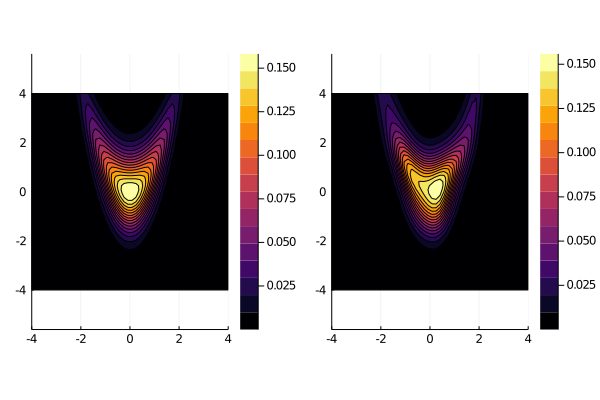

In [189]:
plt = plot(layout = grid(1,2))
contourf!(plt[1,1], xrange, yrange, exp.(logbanana)', ratio = 1, xlim = (xrange[1], xrange[end]))
# scatter!(X[1,:], X[2,:]; legend = false, color = :grey)

contourf!(plt[1,2], xrange, yrange, exp.(logbanana_approx)', ratio = 1, xlim = (xrange[1], xrange[end]))

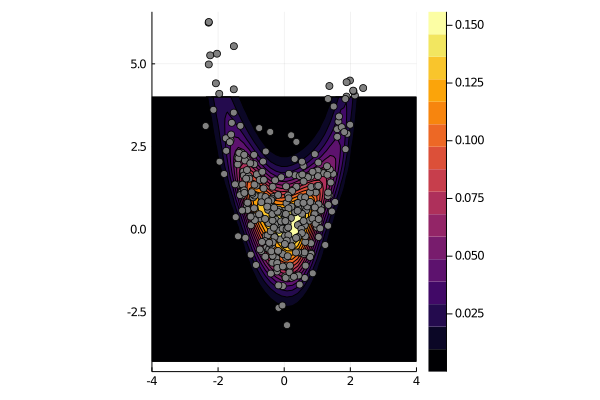

In [190]:
contourf(xrange, yrange, exp.(logbanana_approx)', ratio = 1, xlim = (-Inf, Inf))
scatter!(X[1,:], X[2,:]; legend = false, color = :grey)

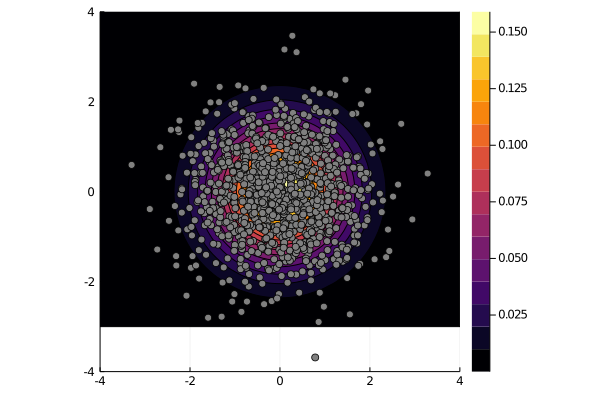

In [156]:
contourf(xrange, yrange, exp.(lognormal)', ratio = 1, xlim = (-4, 4),ylim = (-4, 4))
scatter!(MpushX[1,:], MpushX[2,:]; legend = false, color = :grey)

In [157]:
mean(MpushX; dims = 2)

2×1 Array{Float64,2}:
 -0.027865440753865007
 -0.0004443495484845489

In [158]:
cov(MpushX; dims = 2)

2×2 Array{Float64,2}:
  1.01154    -0.0107189
 -0.0107189   0.98367